### **IOT APLICADA AO MONITORAMENTO DA SAÚDE DE PESSOAS IDOSAS: UM SISTEMA PARA IDENTIFICAÇÃO DE QUEDAS**

---

Objetivo:
Nesse projeto é desenvolvido um sistema de monitoramento das condições de saúde humana, mais especificamente a ocorrência de quedas de pessoas idosas, utilizando dados de indicadores físicos de saúde obtidos através de dispositivos vestíveis como smartwatches a fim de identificar situações atípicas.

---


Instalação de API python para google Sheets

In [ ]:
!pip install --upgrade gspread

Instalação de API python para Office Open XML

In [ ]:
!pip install openpyxl==3.0.5

     |████████████████████████████████| 242 kB 8.0 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


Importação de bibliotecas necessárias

In [ ]:
#Importação de bibliotecas e leitura do dataset
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime,timedelta,time
from sklearn.metrics import classification_report

Autenticação no Drive para acesso ao arquivo de dados

In [ ]:
#Credenciais para o Drive
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

Montagem do drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Detecção de possivel queda
---
Possivel queda:
1. a aceleração deve exceder um limite superior que pode assumir valores de 10 a 18 m / seg2 dependendo do perfil do usuário.
2. Após um intervalo de tempo flexível, a aceleração deve exceder um limite inferior que pode assumir valores de 2 a 7 m / seg2 dependendo novamente do perfil do usuário.

A diferença de tempo entre os dois picos representa a recuperação do usuário após uma queda.
O intervalo de tempo entre o pico mais alto e o mais baixo é flexível, mas não pode exceder os 0,5 segundos, que é a duração máxima do rebote após uma queda de acordo com nossos experimentos.

Se as duas condições forem satisfeitas durante a janela de tempo de 6 segundos, suspeita-se de uma possível queda.

---

Leitura do dataset no drive

In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DataSet.xlsx")

Tratamento de dados: Filtragem e renomeação das colunas do dataset

In [ ]:
#Filtragem e renomeação de colunas do dataset
data = dataset.iloc[0:,[0,29,30,31,43,44,45]] #pulso
#data = dataset.iloc[0:,[0,1,2,3,43,44,45]] #tornozelo
#data = dataset.iloc[0:,[0,8,9,10,43,44,45]] #bolso
#data = dataset.iloc[0:,[0,15,16,17,43,44,45]] #cintura
#data = dataset.iloc[0:,[0,22,23,24,43,44,45]] #pescoço

data.rename(columns={'WristAccelerometer': 'WristAccelerometer - '+ data.iloc[0][1]},inplace=True)
data.rename(columns={'Unnamed: 30': 'WristAccelerometer - '+ data.iloc[0][2]},inplace=True)
data.rename(columns={'Unnamed: 31': 'WristAccelerometer - '+ data.iloc[0][3]},inplace=True)
data['TimeStamps'] = pd.to_numeric(pd.to_datetime(data['TimeStamps'])) / 1e9
data = data.drop(0)
data.head()

data_np = data.to_numpy().astype(np.float) #Conversão do dataframe para array numpy
print(data_np)

Constantes definidas para auxilio com coordenadas

In [ ]:
EIXO_X = 1
EIXO_Y = 2
EIXO_Z = 3

Tratamento de dados: calculo do valor absoluto para ajuste de escala

In [ ]:
for linha in range(data_np.shape[0]):
  for coluna in [EIXO_X, EIXO_Y, EIXO_Z]:
    if abs(data_np[linha, coluna]) > 30:
      data_np[linha, coluna] /= 1000.0

print(data_np)

[[ 1.53070586e+09 -1.24000000e+00 -5.57000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.53070586e+09 -1.24000000e+00 -5.57000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.53070586e+09 -1.88400000e+00 -6.87000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [ 1.53139791e+09  3.18000000e-01  5.55000000e-01 ...  1.70000000e+01
   1.10000000e+01  3.00000000e+00]
 [ 1.53139791e+09  3.21000000e-01  5.61000000e-01 ...  1.70000000e+01
   1.10000000e+01  3.00000000e+00]
 [ 1.53139791e+09  3.08000000e-01  5.48000000e-01 ...  1.70000000e+01
   1.10000000e+01  3.00000000e+00]]


Gera grafico de magnitude de aceleração do dataframe

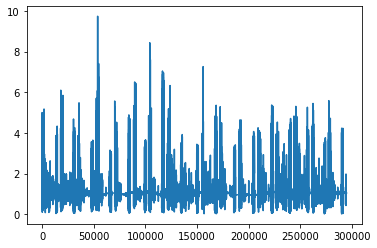

In [ ]:
magnitude_aceleracao = np.sqrt(np.square(data_np[:, EIXO_X]) + np.square(data_np[:, EIXO_Y]) + np.square(data_np[:, EIXO_Z]))
plt.plot(magnitude_aceleracao)

Filtra o dataframe criando lista de amostra dos dados

In [ ]:
def seleciona_dados(data_np, sujeito, atividade, tentativa):
  linhas = []
  for amostra in data_np:
    if amostra[-3] == sujeito and amostra[-2] == atividade and amostra[-1] == tentativa:
      linhas.append(amostra)
  return np.array(linhas)

dados_selecionados = seleciona_dados(data_np, 1, 1, 1)
print(dados_selecionados)
print("tamanho:", dados_selecionados.shape)

[[ 1.53070586e+09 -1.24000000e+00 -5.57000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.53070586e+09 -1.24000000e+00 -5.57000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.53070586e+09 -1.88400000e+00 -6.87000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [ 1.53070587e+09 -6.90000000e-01 -2.87000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.53070587e+09 -6.83000000e-01 -2.71000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.53070587e+09 -6.83000000e-01 -2.71000000e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]]
tamanho: (195, 7)


Remove pastas contendo graficos caso algum erro aconteça

In [ ]:
#os.system("rm -r Sujeito*")

Move as pastas contendo graficos para uma pasta chamada "graficos_tempo" de forma que seja facil mover para o drive depois.

In [ ]:
os.system("mkdir graficos_tempo")
os.system("mv Sujeito_* graficos_tempo")

0

Função para geração de gráficos com base na aceleração e duração dos eventos

In [ ]:
def gera_graficos(data_np):
  # indices negativos acessam os dados de tras para frente. O -1 eh o ultimo item.
  sujeitos = np.unique(data_np[:, -3])
  atividades = np.unique(data_np[:, -2])
  tentativas = np.unique(data_np[:, -1])

  for i in tqdm(sujeitos):
    i = int(i)
    path = 'Sujeito_' + str(i) + '/'

    if not os.path.exists(path):
      os.mkdir(path)

    for j in atividades:
      j = int(j)

      for k in tentativas:
        k = int(k)

        dados_sujeito = seleciona_dados(data_np, i, j, k)
        if len(dados_sujeito) <= 5:
          continue

        magnitude_aceleracao = np.sqrt(np.square(dados_sujeito[:, EIXO_X]) + np.square(dados_sujeito[:, EIXO_Y]) + np.square(dados_sujeito[:, EIXO_Z]))
        tempos = dados_sujeito[:, 0] - dados_sujeito[0, 0]

        nome = path + 's' + str(i) + '_a' + str(j) + '_t' + str(k) + '.png'
        fig = plt.figure()

        plt.plot(tempos, magnitude_aceleracao, label='Aceleração')
        plt.ylabel('Aceleração (m/seg²)')
        plt.xlabel('tempo (s)')
        #plt.axis([0, 50000, 0, 1000000]) # [xmin, xmax, ymin, ymax]
        plt.legend()
        fig.savefig(nome, format='png')
        plt.close(fig)

gera_graficos(data_np)


Constantes para analise dos eventos de queda

In [ ]:
LIMIAR_SUPERIOR_ACELERACAO_QUEDA = 2
LIMIAR_INFERIOR_ACELERACAO_QUEDA = 1.5
NUM_PICOS_ATIVIDADES_DINAMICAS = 5

Classificação de eventos de queda com base apenas no limiar superior de aceleração

In [ ]:
def classifica_atividade_simples(dados_sujeito):
  magnitude_aceleracao = np.sqrt(np.square(dados_sujeito[:, EIXO_X]) + np.square(dados_sujeito[:, EIXO_Y]) + np.square(dados_sujeito[:, EIXO_Z]))
  n_picos = 0

  for valor_aceleracao in magnitude_aceleracao:
    if valor_aceleracao > LIMIAR_SUPERIOR_ACELERACAO_QUEDA:
      n_picos += 1

  #print(n_picos)
  houve_queda = False
  if (n_picos > 0) and (n_picos < 0.1 * len(magnitude_aceleracao)):
    houve_queda = True

  return houve_queda


Classificação de eventos de queda com base limiar superior de aceleração, limiar inferior de aceleração,  janela de tempo de 5 seg e tempo entre picos de 0.5 seg

In [ ]:
def classifica_atividade_paper(dados_sujeito):
  magnitude_aceleracao = np.sqrt(np.square(dados_sujeito[:, EIXO_X]) + np.square(dados_sujeito[:, EIXO_Y]) + np.square(dados_sujeito[:, EIXO_Z]))
  tempos = dados_sujeito[:, 0]
  n_picos = 0

  for idx, valor_aceleracao in enumerate(magnitude_aceleracao):
    valor_aceleracao = magnitude_aceleracao[idx]
    if valor_aceleracao > LIMIAR_SUPERIOR_ACELERACAO_QUEDA:
      idx_janela0_5 = idx + 1
      while (idx_janela0_5 < len(tempos)) and (tempos[idx_janela0_5] - tempos[idx] < 0.5):
        if (magnitude_aceleracao[idx_janela0_5] > LIMIAR_INFERIOR_ACELERACAO_QUEDA): #and (magnitude_aceleracao[idx_janela0_5] < LIMIAR_SUPERIOR_ACELERACAO_QUEDA):
          n_picos += 1
          break
        idx_janela0_5 += 1

  #print(n_picos)
  houve_queda = False
  if (n_picos >= 1) and (n_picos <= 10):
    houve_queda = True

  return houve_queda

Seleciona amostra de dados do dataframe e analisa se houve queda

In [ ]:
dados_sujeito = seleciona_dados(data_np, 1, 10, 1)
print("houve queda:", classifica_atividade_paper(dados_sujeito))

houve queda: False


Calculo das metricas de performance do algoritmo: acurácia, precisão,
revocação e f1-score

In [ ]:
def calcula_metricas_performance(data_np, funcao_classificao_queda):
  saidas_verdadeiras = []
  saidas_preditas = []

  # indices negativos acessam os dados de tras para frente. O -1 eh o ultimo item.
  sujeitos = np.unique(data_np[:, -3])
  atividades = np.unique(data_np[:, -2])
  tentativas = np.unique(data_np[:, -1])

  for i in tqdm(sujeitos):
    for j in atividades:
      for k in tentativas:
        dados_sujeito = seleciona_dados(data_np, i, j, k)
        if len(dados_sujeito) <= 5:
          continue

        predicao = funcao_classificao_queda(dados_sujeito)
        label = j in [1, 2, 3, 4, 5]

        saidas_verdadeiras.append(label)
        saidas_preditas.append(predicao)

  print("\n", classification_report(saidas_verdadeiras, saidas_preditas))

#calcula_metricas_performance(data_np, classifica_atividade_simples)
calcula_metricas_performance(data_np, classifica_atividade_paper)

100%|██████████| 17/17 [01:04<00:00,  3.79s/it]


               precision    recall  f1-score   support

       False       0.94      0.89      0.91       304
        True       0.87      0.93      0.90       255

    accuracy                           0.91       559
   macro avg       0.91      0.91      0.91       559
weighted avg       0.91      0.91      0.91       559

